#     Gaussian Process Regression

Let's begin with importing the required libraries:

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    WhiteKernel,
    ExpSineSquared
)
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm

# for saving data files
import pandas as pd

In [2]:
# Initialize X/Y with hand/end-eff data, respectively, from first run
set_num=0 
run = 1
data = np.load("C:\\Users\\jmoln\\Documents\\Projects\\NonAnthroHands_User_Study\\data\\positions\\positions_"+str(set_num)+"_data\\DTW_processed_data\\data_"+str(set_num)+"_"+str(run)+".npz")
# joints = np.load("C:\\Users\\jmoln\\Documents\\Projects\\NonAnthroHands_User_Study\\data\\positions\\corrected_positions.csv")
print(sorted(data.files))

x = np.hstack((data['hand_pos_aligned'], data['hand_rot_aligned']))
y = np.hstack((data['end_eff_pos_aligned'], data['end_eff_rot_aligned']))

# Concatenate data for the rest of the runs, leaving one out to be the test set
skipval = 2 # Identify the run that will serve as the test dataset

for set_num in range(0,3):
    for run in range (2,11):
        if set_num==skipval : 
            continue
        else :
            data = np.load("C:\\Users\\jmoln\\Documents\\Projects\\NonAnthroHands_User_Study\\data\\positions\\positions_"+str(set_num)+"_data\\DTW_processed_data\\data_"+str(set_num)+"_"+str(run)+".npz")
            x_temp = np.hstack((data['hand_pos_aligned'], data['hand_rot_aligned']))
            y_temp = np.hstack((data['end_eff_pos_aligned'], data['end_eff_rot_aligned']))
            x = np.vstack((x,x_temp))
            y = np.vstack((y,y_temp))

run=8
data_test = np.load("C:\\Users\\jmoln\\Documents\\Projects\\NonAnthroHands_User_Study\\data\\positions\\positions_"+str(skipval)+"_data\\DTW_processed_data\\data_"+str(skipval)+"_"+str(run)+".npz")
x_star = np.hstack((data_test['hand_pos_aligned'], data_test['hand_rot_aligned']))
y_test = np.hstack((data_test['end_eff_pos_aligned'], data_test['end_eff_rot_aligned']))

['end_eff_data', 'end_eff_pos_aligned', 'end_eff_rot_aligned', 'hand_data', 'hand_pos_aligned', 'hand_rot_aligned', 'run', 'set_num', 'time_URDF_aligned', 'time_hand_aligned', 'warp_path']


In [3]:
# run = 2
# data = np.load("C:\\Users\\jmoln\\Documents\\Projects\\NonAnthroHands_User_Study\\data\\positions\\positions_0_data\\DTW_processed_data\\ja_data_0_"+str(run)+".npz")

# # Construction of Sklearn's Regression and Selection of the Kernel
# kernel = RBF()
# gp_regressor = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True)
# x = data['hand_data_aligned']
# x = x[...,1:6]
# y = data['ja_data_aligned']
# y = y[...,1:6]
# gp_regressor.fit(x,y)
# print(f"RBF Lengthscale: {gp_regressor.kernel_}")

# y_pred_mean, y_pred_std = gp_regressor.predict(x_star, return_std=True)

# df = pd.DataFrame(y_pred_mean)
# df.to_csv('trained_ja_mean.csv')
# df = pd.DataFrame(y_pred_std)
# df.to_csv('trained_ja_std.csv')

In [ ]:
# Construction of Sklearn's Regression and Selection of the Kernel
kernel = RBF()
gp_regressor = GaussianProcessRegressor(kernel=kernel, alpha=1.0, normalize_y=True)
gp_regressor.fit(x, y)
print(f"RBF Lengthscale: {gp_regressor.kernel_}")

y_pred_mean, y_pred_std = gp_regressor.predict(x_star, return_std=True)

df = pd.DataFrame(y_pred_mean)
df.to_csv('trained_endeff_mean.csv')
df = pd.DataFrame(y_pred_std)
df.to_csv('trained_endeff_std.csv')

In [ ]:
# Plotting the Predicted Values
labels=('Position','Orientation')

for i in range(2):
    fig, ax = plt.subplots(figsize=(15, 10))

    # Show the border and axes ticks
    fig.patch.set_visible(True)
    ax = plt.axes(projection='3d')
    ax.axis('on')
    ax.view_init(-140, 20)
    
    ax.scatter(y_pred_mean[:].T[3*i+0], -y_pred_mean[:].T[3*i+2], y_pred_mean[:].T[3*i+1],c='lightcoral') #, c=time_URDF_aligned/max(time_URDF_aligned), cmap='Reds', label='End-effector orientation')
    ax.scatter(y_pred_mean[:].T[3*i+0], -y_pred_mean[:].T[3*i+2], y_pred_mean[:].T[3*i+1],c='lightcoral', alpha = 0.05, s=y_pred_std)
    #     ax.legend([(prediction, error)], ['merged'])
    ax.scatter(y_test[:].T[3*i+0]    , -y_test[:].T[3*i+2]      , y_test[:].T[3*i+1],c='skyblue')   #, c=time_hand_aligned/max(time_hand_aligned), cmap='Blues', label='Hand orientation')

# for [map_x, map_y] in warp_path: 
#     ax.plot3D([y_pred_mean[map_x].T[3*i+0], y_test[map_y].T[3*i+0]], \
#               [-y_pred_mean[map_x].T[3*i+2], -y_test[map_y].T[3*i+2]],\
#               [y_pred_mean[map_x].T[3*i+1], y_test[map_y].T[3*i+1]], \
#               '--k', linewidth=0.2)

    ax.set_xlabel('Horizontal '+labels[i])
    ax.set_ylabel('Forward/Back '+labels[i])
    ax.set_zlabel('Vertical '+labels[i])
    ax.set_title("Comparison of Expected and Actual End-Effector "+labels[i], fontsize=10, fontweight="bold")

    plt.savefig('GPR_output_'+labels[i]+'.png')
    
    plt.close('all')



In [ ]:
f = plt.figure(figsize=[17.0, 5.0])

ax = f.add_subplot(121)
labels = ('X','Y','Z')
errorlabels = ('One STD')
for i in range(1,4):
    ax.plot(y_pred_mean[:].T[i],label='Pos '+labels[i-1])
    ax.plot(y_test[:].T[i])
#     ax.plot(y_pred_std[:].T[i],linewidth=)
    if i==3:
        ax.plot(np.squeeze(y_pred_mean.T[i]) + y_pred_std.T[i], 'k--',label='One STD')
    else:
        ax.plot(np.squeeze(y_pred_mean.T[i]) + y_pred_std.T[i], 'k--')
    ax.plot(np.squeeze(y_pred_mean.T[i]) - y_pred_std.T[i], 'k--')
ax.set_xlabel('X');
ax.set_ylabel('Y');
ax.set_title('Predicted vs actual end effector position');
ax.legend();
plt.savefig('Error.png')
plt.close('all')

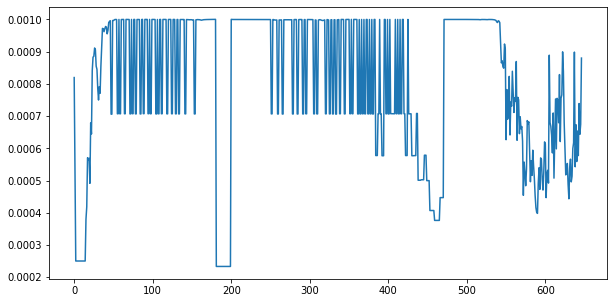

In [207]:
f = plt.figure(figsize=[10.0, 5.0])
ax = f.add_subplot(111)
ax.plot(y_pred_std);
